In [304]:
import pandas as pd
import requests
import numpy as np

In [ ]:
api_key_EIA = 'your_api_key_here'  # Replace with your actual API key

url = f"https://api.eia.gov/v2/co2-emissions/co2-emissions-aggregates/data/?frequency=annual&data[0]=value&facets[sectorId][]=EC&start=1990&end=1996&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key_EIA}"

data_all = []
# Maximum length of EIA API output is 5000 rows; while loop below gets all rows
while True:
    response = requests.get(url)
    
    # Print status code for debugging
    print(f"Status Code: {response.status_code}")
    
    # If there's an error, print the full response
    if response.status_code == 200:
        print("Request successful")
    else:
        print(f"Request failed with status code: {response.status_code}")
        break
    
    data = response.json()
    
    if "response" not in data or "data" not in data["response"]:
        print("Unexpected response structure:", data)
        break
    
    data_all.extend(data["response"]["data"])
    
    if len(data["response"]["data"]) < 5000:
        break
    
    data['offset'] += 5000

states_total = pd.DataFrame(data_all)
print(len(states_total))

Status Code: 200
Request successful
1456


In [310]:
# drop unnecessary columns and rows for 'US', 'AK', 'HI':
states_total = states_total.loc[states_total['fuelId']=='TO']

states_total = states_total[['period', 'stateId', 'value']]

states_total = states_total.drop(states_total[states_total['stateId'].isin(['US', 'AK', 'HI'])].index)

In [311]:
# rename columns
states_total = states_total.rename(columns={'period': 'year', 'stateId': 'state', 'value': 'total_co2'})

In [312]:
states_total['total_co2'] = states_total['total_co2'].astype(float)*1000000

In [313]:
states_total

,year,state,total_co2
1,1996,WY,40630558.0
5,1996,WI,39691630.0
9,1996,WV,78739642.0
13,1996,WA,10737829.0
17,1996,VA,33564559.0
...,...,...,...
1439,1990,VA,23438072.0
1443,1990,WA,7532108.0
1447,1990,WV,71001562.0
1451,1990,WI,33198849.0


The EIA data on emissions give us yearly data. We will estimate monthly emissions using monthly data on power production for all states (2001-2024) from Ember to get monthly weights. We will construct these monthly weights by decomposing monthly power production data using the `seasonal_decompose` function from the `statsmodels` package. 

In [314]:
# Get monthly electricity data from Ember
url = "https://storage.googleapis.com/emb-prod-bkt-publicdata/public-downloads/us_monthly_full_release_long_format.csv"
monthly_electricity = pd.read_csv(url)

In [315]:
monthly_electricity

,Country,Country code,State,State code,State type,Date,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
0,United States of America,USA,Alabama,AL,state,2001-01-01,Electricity generation,Aggregate fuel,Clean,%,35.93,NaN,NaN
1,United States of America,USA,Alabama,AL,state,2001-01-01,Electricity generation,Aggregate fuel,Fossil,%,64.07,NaN,NaN
2,United States of America,USA,Alabama,AL,state,2001-01-01,Electricity generation,Aggregate fuel,Gas and Other Fossil,%,6.18,NaN,NaN
3,United States of America,USA,Alabama,AL,state,2001-01-01,Electricity generation,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",%,9.97,NaN,NaN
4,United States of America,USA,Alabama,AL,state,2001-01-01,Electricity generation,Aggregate fuel,Renewables,%,9.97,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
829247,United States of America,USA,Wyoming,WY,state,2024-08-01,Power sector emissions,Fuel,Hydro,ktCO2,1.87,1.87,NaN
829248,United States of America,USA,Wyoming,WY,state,2024-08-01,Power sector emissions,Fuel,Other Fossil,ktCO2,28.04,2.23,8.64
829249,United States of America,USA,Wyoming,WY,state,2024-08-01,Power sector emissions,Fuel,Solar,ktCO2,2.82,1.73,158.72
829250,United States of America,USA,Wyoming,WY,state,2024-08-01,Power sector emissions,Fuel,Wind,ktCO2,5.95,-0.05,-0.83


In [316]:
monthly_electricity = monthly_electricity.loc[(monthly_electricity['Category']=='Electricity generation') & (monthly_electricity['Subcategory']=='Total')]

In [317]:
monthly_electricity = monthly_electricity[['State code', 'Date', 'Variable', 'Unit', 'Value']]

In [318]:
monthly_electricity['month'] = pd.to_datetime(monthly_electricity['Date']).dt.month

In [319]:
total_generation = monthly_electricity.groupby('Date')['Value'].sum()


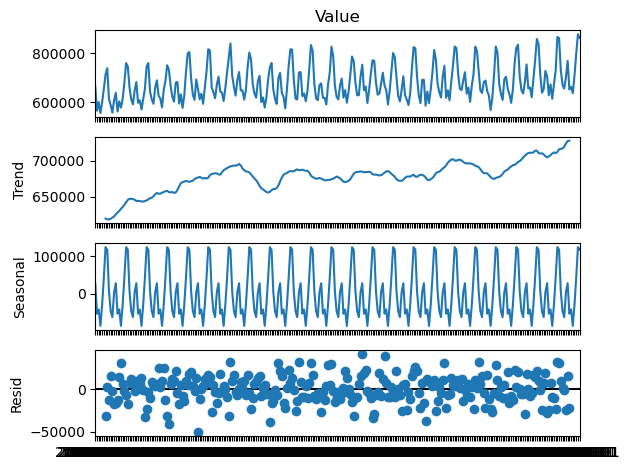

In [320]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
decomposition = seasonal_decompose(total_generation, model='additive', period=12)
decomposition.plot()
plt.show()

In [321]:
seasonal_adjustment = pd.DataFrame({"Date":decomposition.seasonal.index, "Seasonal adjustment":decomposition.seasonal.values})

In [322]:
seasonal_adjustment['Date'] = pd.to_datetime(seasonal_adjustment['Date'])

In [323]:
seasonal_adjustment['Month'] = seasonal_adjustment['Date'].dt.month

In [324]:
seasonal_weights = seasonal_adjustment.groupby('Month')['Seasonal adjustment'].mean()

We want our vector of monthly weights to be standardized and non-negative. To do this, we first take the z-scores of monthly weights and then apply an exponential transformation. This centers our weights at 1 and ensures our weights are non-negative.

In [325]:
seasonal_weights_transformed = np.exp((seasonal_weights - np.mean(seasonal_weights)) / np.std(seasonal_weights))

In [326]:
seasonal_weights_transformed

Month
1     1.531550
2     0.438485
3     0.522708
4     0.266173
5     0.633318
6     1.923449
7     6.722730
8     6.052299
9     1.096209
10    0.488352
11    0.380949
12    1.058841
Name: Seasonal adjustment, dtype: float64

In [327]:
# Create a new month column using a cross-join
months = pd.DataFrame({'month': range(1,13)})
states_total = states_total.merge(months, how='cross')

In [328]:
states_total

,year,state,total_co2,month
0,1996,WY,40630558.0,1
1,1996,WY,40630558.0,2
2,1996,WY,40630558.0,3
3,1996,WY,40630558.0,4
4,1996,WY,40630558.0,5
...,...,...,...,...
4111,1990,WY,39612532.0,8
4112,1990,WY,39612532.0,9
4113,1990,WY,39612532.0,10
4114,1990,WY,39612532.0,11


We now construct monthly emissions for each state-year pair by multiplying the total level of CO2 by a dictionary of weights and dividing by the sum of weights to ensure that monthly emissions for each state-year pair sum to the total amount:

In [329]:
states_total['monthly_emissions'] = states_total['total_co2'] * states_total['month'].map(dict(seasonal_weights_transformed)) / np.sum(seasonal_weights_transformed)

In [330]:
# Remove total_co2 column
states_total = states_total.drop(columns=['total_co2'])

In [331]:
states_total.to_csv("monthly_emissions_1990_96.csv",index=False)